In [54]:
%matplotlib inline
from autograd import numpy as np
import autograd
import bayesian_pdes as bpdes
from scipy import stats, linalg
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import eit
import time
import scipy.optimize
%load_ext mcmc
%mcmc notebook

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [55]:
from IPython.core.magic import register_cell_magic, needs_local_scope
@needs_local_scope
@register_cell_magic
def capture_cell(line, cell):
    globals()[line.strip()] = cell
    exec(cell, globals())

In [56]:
%%capture_cell params
scale = 1000
kernel_variance_mult = 100.0
kernel_ls = 0.3
conductivity_variance_mult = 1.0 # 1e-3 is good
conductivity_ls = 0.3

n_repeats = 50000
n_iter = 100
thin = 100

likelihood_variance = 5.0 # variance for the observation model - based on the value from RA paper
design_file = None
n_rings = 7
n_conductivity_rings = 8
adapt_ls = True
bayesian = False

restart = True

# Sheet Parameters

In [57]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [58]:
# load in observational data

voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000r.txt')
current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')
#voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006r.txt') # empty tank
amps = voltage_file[0]

currents = np.empty((31, 32))
voltages = np.empty((31, 32))
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages = voltage_file[32*i+1:32*(i+1)+1]
    currents[i] = this_currents
    voltages[i] = this_voltages

In [59]:
# code for setting up the stim pattern
stim_pattern = currents*scale*amps

In [60]:
meas_pattern = np.eye(32)

In [61]:
pattern = eit.grids.EITPattern(meas_pattern, stim_pattern)

In [62]:
data = voltages

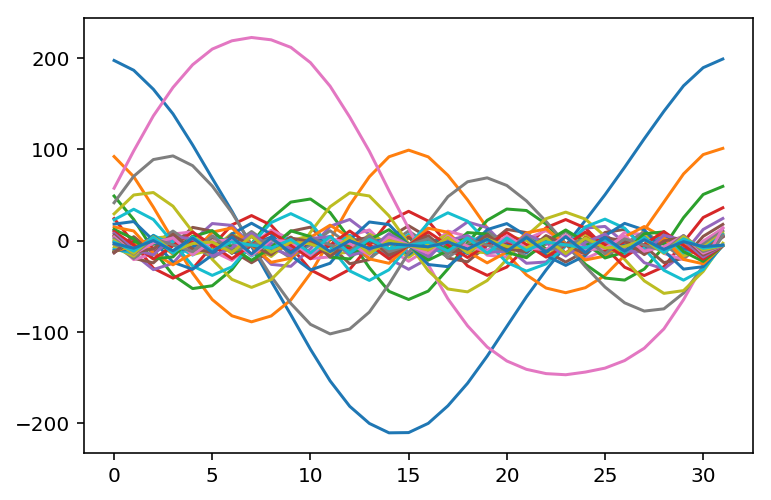

In [63]:
plt.plot(data.T);

In [64]:
# load in reference data
ref_voltage_file = np.loadtxt('dummy_data/voltages.txt')
ref_voltages = np.empty((31, 32))
for i in range(len(current_file) / 32):
    this_voltages = ref_voltage_file[32*i+1:32*(i+1)+1]
    ref_voltages[i] = this_voltages
%run -i dummy_data/function.py

## Define the collocation grid

In [65]:
n_bdy = 64
n_sensor = 32
if design_file is None:
    grid = eit.grids.construct_circular(n_rings, n_bdy, n_sensor)
    design_name = 'regular_n={}'.format(len(grid.interior_plus_boundary))
    if not bayesian:
        design_name += '_collocate'
else:
    design_name = design_file
    sensors = eit.pol2cart(np.c_[np.ones(n_sensor+1), np.linspace(0, 2*np.pi, n_sensor+1)])[:-1]
    design = np.load(os.path.join('eit_designs', design_name + '.npy'))
    grid = eit.grids.EITGrid(design, None, sensors)
    if not bayesian:
        design_name += '_collocate'
print len(grid.interior_plus_boundary)

209


In [66]:
dest = os.path.join('eit_results', design_name)

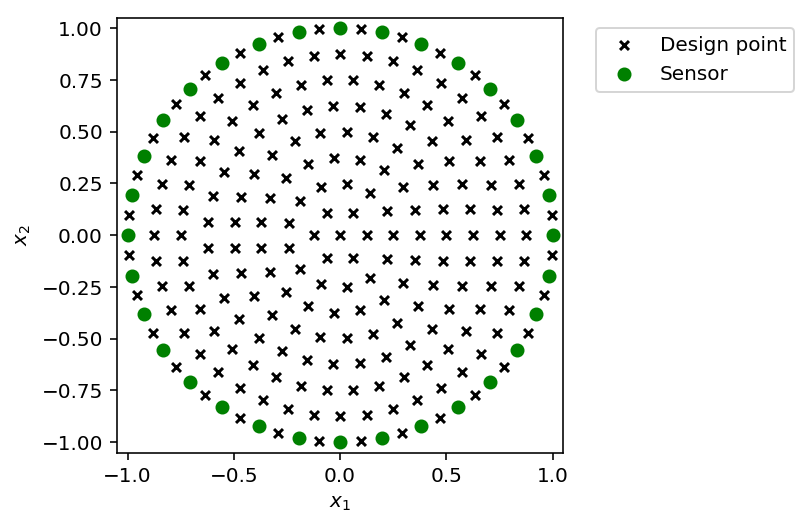

In [67]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=20)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=20, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='o', color='green', label='Sensor')
plt.xlim(-1.05,1.05);plt.ylim(-1.05,1.05)
lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.savefig('figures/eit_regular_design_n={}.pdf'.format(len(grid.interior_plus_boundary)), bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)

## Set up Proposal Matrix

In [68]:
s_x,s_y,s_xbar,s_ybar = sp.symbols('x_1 x_2 y_1 y_2')
s_length_scale, s_variance = sp.symbols('ls, sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))

In [69]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [70]:
proposal_design = eit.grids.construct_shell(np.linspace(0,1,n_conductivity_rings))
print len(proposal_design)

177


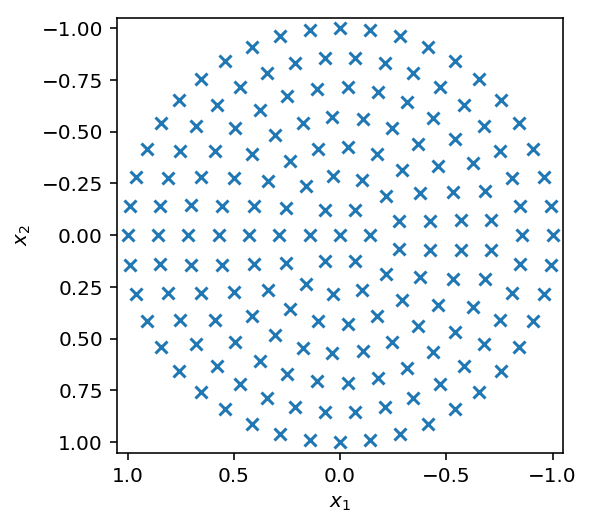

In [71]:

plt.figure(figsize=(4,4))
plt.scatter(proposal_design[:,0], proposal_design[:,1], marker='x')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)

#plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
#plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig('figures/eit_conductivity_design.pdf', transparent=True, bbox_inches='tight')

In [72]:
full_design = np.row_stack([grid.interior_plus_boundary, grid.sensors])
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, grid.interior_plus_boundary, grid.interior_plus_boundary],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646662752.2742453

In [73]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)

In [74]:
ref_field = field_fun(proposal_design[:,0], proposal_design[:,1], centers, width)

# Set Up The Potential

In [75]:
# this is just the length_scale for the initial field
fun_args_tmp = np.array([kernel_ls, kernel_variance_mult])


In [76]:
# choose an initial field
def phi_const(k):
    theta = k*np.ones(proposal_cov.shape[0])
    return eit.pcn_kernel.phi_c(grid, theta, likelihood_variance, pattern, data, fun_args_tmp, proposal_dot_mat)


In [77]:
best_const = scipy.optimize.minimize_scalar(phi_const)
kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])
if restart:
    kappa_0 = np.load(os.path.join(dest, 'results.npy'))[-1,:]

In [78]:
def phi_ls(ls, data, kappa):
    fa = np.array([ls, kernel_variance_mult])
    return eit.pcn_kernel.phi_c(grid, kappa, likelihood_variance, pattern, data, fa, proposal_dot_mat)

In [79]:
# now choose the length scale by optimizing marginal likelihood
best_ls = scipy.optimize.minimize_scalar(phi_ls, method='bounded', bounds=(0,1), args=(ref_voltages, ref_field))
length_scale = best_ls.x
print length_scale
if restart:
    length_scale = np.load(os.path.join(dest, 'length_scales.npy'))[-1]

0.320507429955


In [80]:
#length_scale = 0.3

In [81]:
fun_args = np.array([length_scale, kernel_variance_mult])
# construct the proposal
beta = 0.05
min_accept, max_accept = 0.1, 0.4
prior_mean = best_const.x*np.ones(proposal_cov.shape[0])
sqrt_proposal_cov = np.real_if_close(linalg.sqrtm(proposal_cov))

pcn_kernel = eit.pcn_kernel.PCNKernel_C(beta, prior_mean, sqrt_proposal_cov, grid, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)


In [82]:
mu, cov = pcn_kernel.get_posterior(kappa_0, grid.sensors)
print np.mean(np.diag((cov))), np.std(np.diag(cov))

5.9134069341 0.000821675666152


In [83]:
start = kappa_0.reshape((1, kappa_0.shape[0]), order='F')

In [ ]:
def ls_log_prior(ls):
    if ls < 0:
        return -np.inf
    return scipy.stats.halfcauchy.logpdf(ls)

In [ ]:
%%time
beta = 0.05
per_repeat = n_iter/thin
res = np.empty((per_repeat*n_repeats, kappa_0.shape[0]))

cur_length_scale = length_scale
pcn_kernel.collocate_args = np.array([cur_length_scale, kernel_variance_mult])
length_scales = np.empty(n_repeats)
length_scale_proposals = np.empty(n_repeats)
accepts = np.zeros(n_repeats, dtype=np.bool)
length_scale_proposal_variance = 1e-3
cur_ls_log_prior = ls_log_prior(length_scale)

for i in xrange(n_repeats):
    proposals, acceptances, log_likelihoods = pcn_kernel.apply(start, n_iter, n_threads=8, beta=beta, bayesian=bayesian)
    if acceptances.mean() < min_accept:
        beta *= 0.75
    elif acceptances.mean() > max_accept:
        beta /= 0.75
    res[per_repeat*i:per_repeat*(i+1)] = proposals[::thin]
    start = proposals[-1,:].reshape(start.shape, order='F')
    
    if adapt_ls:
        # propose to change length_scale
        new_length_scale = np.random.normal(cur_length_scale, length_scale_proposal_variance)
        length_scale_proposals[i] = new_length_scale
        new_ls_log_prior = ls_log_prior(new_length_scale)

        if np.isneginf(new_ls_log_prior):
            accept = False
        else:
            cur_phi = pcn_kernel.phi(start.ravel())
            new_phi = pcn_kernel.phi(start.ravel(), np.array([new_length_scale, kernel_variance_mult]))
            accept_prob = np.exp(cur_phi - new_phi + new_ls_log_prior - cur_ls_log_prior)
            accept = np.random.uniform() < accept_prob
        if accept:
            cur_length_scale = new_length_scale
            cur_ls_log_prior = new_ls_log_prior
            pcn_kernel.collocate_args = np.array([cur_length_scale, kernel_variance_mult])
    else:
        accept = False
    accepts[i] = accept
    length_scales[i] = cur_length_scale
    if i > 100:
        if np.mean(accepts[i-99:i+1]) < min_accept:
            length_scale_proposal_variance *= 0.75
        elif np.mean(accepts[i-99:i+1]) > max_accept:
            length_scale_proposal_variance /= 0.75
        
    if i % 100 == 0:
        print '{}: accept={} beta={} ls={} accept={}'.format(i, acceptances.mean(), beta, cur_length_scale, np.mean(accepts[:i+1]))
#print log_likelihoods.mean()

0: accept=0.0 beta=0.0375 ls=0.297358505135 accept=1.0


In [ ]:
plt.plot(res[500:,0])

In [ ]:
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(res[-1,:]))

In [ ]:
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(np.mean(res[500:], axis=0)))

In [ ]:
dest = os.path.join('eit_results', design_name)
if not os.path.exists(dest):
    os.makedirs(dest)
np.save(os.path.join(dest, 'results.npy'), res)
np.save(os.path.join(dest, 'design.npy'), grid.interior_plus_boundary)
np.save(os.path.join(dest, 'field_pts.npy'), proposal_design)
np.save(os.path.join(dest, 'length_scales.npy'), length_scales)
with open(os.path.join(dest, 'params.py'), 'wb') as f:
    f.write(params)